In [1]:
import warnings
    
# Settings the warnings to be ignored
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
import datetime

# second part
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy import stats

import statsmodels.tsa.api as ts

from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

from sklearn.metrics import r2_score
from darts.metrics.metrics import rmse, r2_score
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel

from sklearn.preprocessing import StandardScaler
from darts.dataprocessing.transformers import Scaler
from darts import concatenate as ts_concat

from darts.models.forecasting.varima import VARIMA
from darts.timeseries import TimeSeries as TS
from darts.models.forecasting.random_forest import RandomForest
from darts.models import ExponentialSmoothing

import statsmodels as sm
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR


import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})


In [2]:
%%time
df = pd.read_csv('./data/full_data_sum.csv')
df['date'] = pd.to_datetime(df['date'])
df['dt'] = pd.to_datetime(df.date) + df.hour.astype('timedelta64[h]')

CPU times: user 1.58 s, sys: 160 ms, total: 1.74 s
Wall time: 1.75 s


In [3]:
series = ['internet', 'sms_in', 'sms_out', 'call_in', 'call_out']
nans = df[series].isna().groupby(df.square_id).sum().reset_index().set_index('square_id') / 1488

In [4]:
# Проверим есть ли пропуски в колонках
nans.T.sum(axis=1)

internet    0.0
sms_in      0.0
sms_out     0.0
call_in     0.0
call_out    0.0
dtype: float64

#### Распределение значений рядов, АКФ

In [5]:
def standardize_group(series):
    return (series - series.mean()) / series.std()

def vis_col(input_data: pd.DataFrame, 
            col: str,
            scaled=False):
    """
    
    """
    
    df_ = input_data.copy()
    
    # стандартизируем значения колонки
    if scaled:
        df_[col] = df_.groupby('square_id')[col].transform(standardize_group)
        
        
        
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(30,15))
    # оси для первых двух графиков
    ax1 = axs[0, 0]
    ax2 = axs[0, 1]

    # ось для большого графика
    gs = axs[0, 1].get_gridspec()
    
    axs[1, 0].remove()
    axs[1, 1].remove()
    axs[0, 2].remove()
    axs[0, 3].remove()
    axs[1, 2].remove()
    axs[1, 3].remove()
    
    ax3 = fig.add_subplot(gs[1, 0:2])
    
    # область для графика АКФ
    ax4 = fig.add_subplot(gs[0:1, 2:4])
    
    # область для графика Частной АКФ
    ax5 = fig.add_subplot(gs[1, 2:4])
    
    
    example = df_[df_.square_id==1150].set_index('date')[col]
    
    # подсчитываем усредненное значение интернет-нагрузки за каждый час
    _agg = df_.groupby(['date', 'hour'])[col].mean()
    # оставляем в индексе только дату
    _agg = _agg.reset_index().set_index('date')[col]


    #plot1
    sns.histplot(df_[col], bins=100, ax=ax1).set(title=f'Распределение значений {col}');
    
    #plot2
    sns.lineplot(x=example.index,
                 y=example.values,
                 errorbar='ci',
                 err_style='band', ax=ax2).set(title=f'Пример изменения {col} на одной станции');
    ax2.tick_params(axis='x', rotation=45)
    
    #plot3
    sns.lineplot(data=_agg,
                 errorbar='ci',
                 err_style='band', ax=ax3).set(title=f'Изменение среднего значения {col} за исследуемый период');
    ax3.tick_params(axis='x', rotation=45)
    
    #plot4
    nlags = 24 * 7 
    corrs, ccnf_intervals = ts.acf(_agg, nlags=nlags, alpha=.05)
    sns.barplot(x=np.arange(0,nlags+1), y=corrs, ax=ax4).set(title=f'АКФ признака {col} за периоды от 1 до {nlags} часов');
    ax4.xaxis.set_ticks(np.arange(0, nlags+1, 10))
    ax4.tick_params(axis='x', rotation=45)
    
    
    
    nlags = 72
    corrs, ccnf_intervals = ts.pacf(_agg, nlags=nlags, alpha=.05)
    sns.barplot(x=np.arange(0,nlags+1), y=corrs, ax=ax5).set(title=f'Частная АКФ признака {col} за периоды от 1 до {nlags} часов');
    ax5.xaxis.set_ticks(np.arange(0, nlags+1, 10))
    ax5.tick_params(axis='x', rotation=45)


    

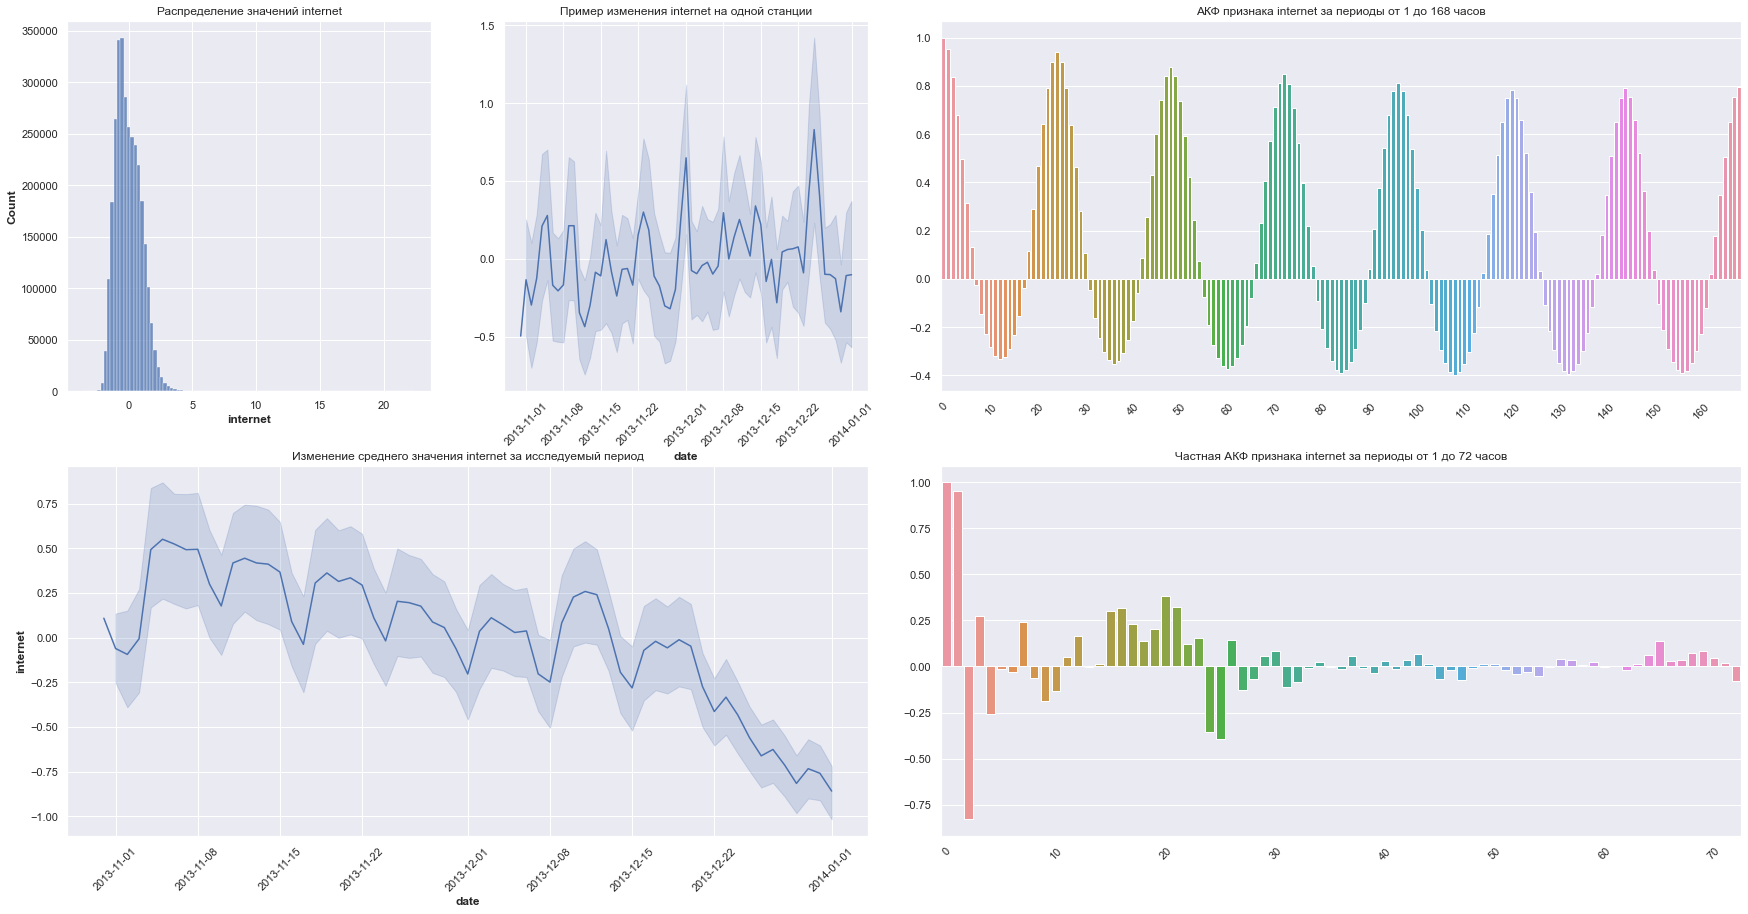

In [6]:
vis_col(df, 'internet', scaled=True)

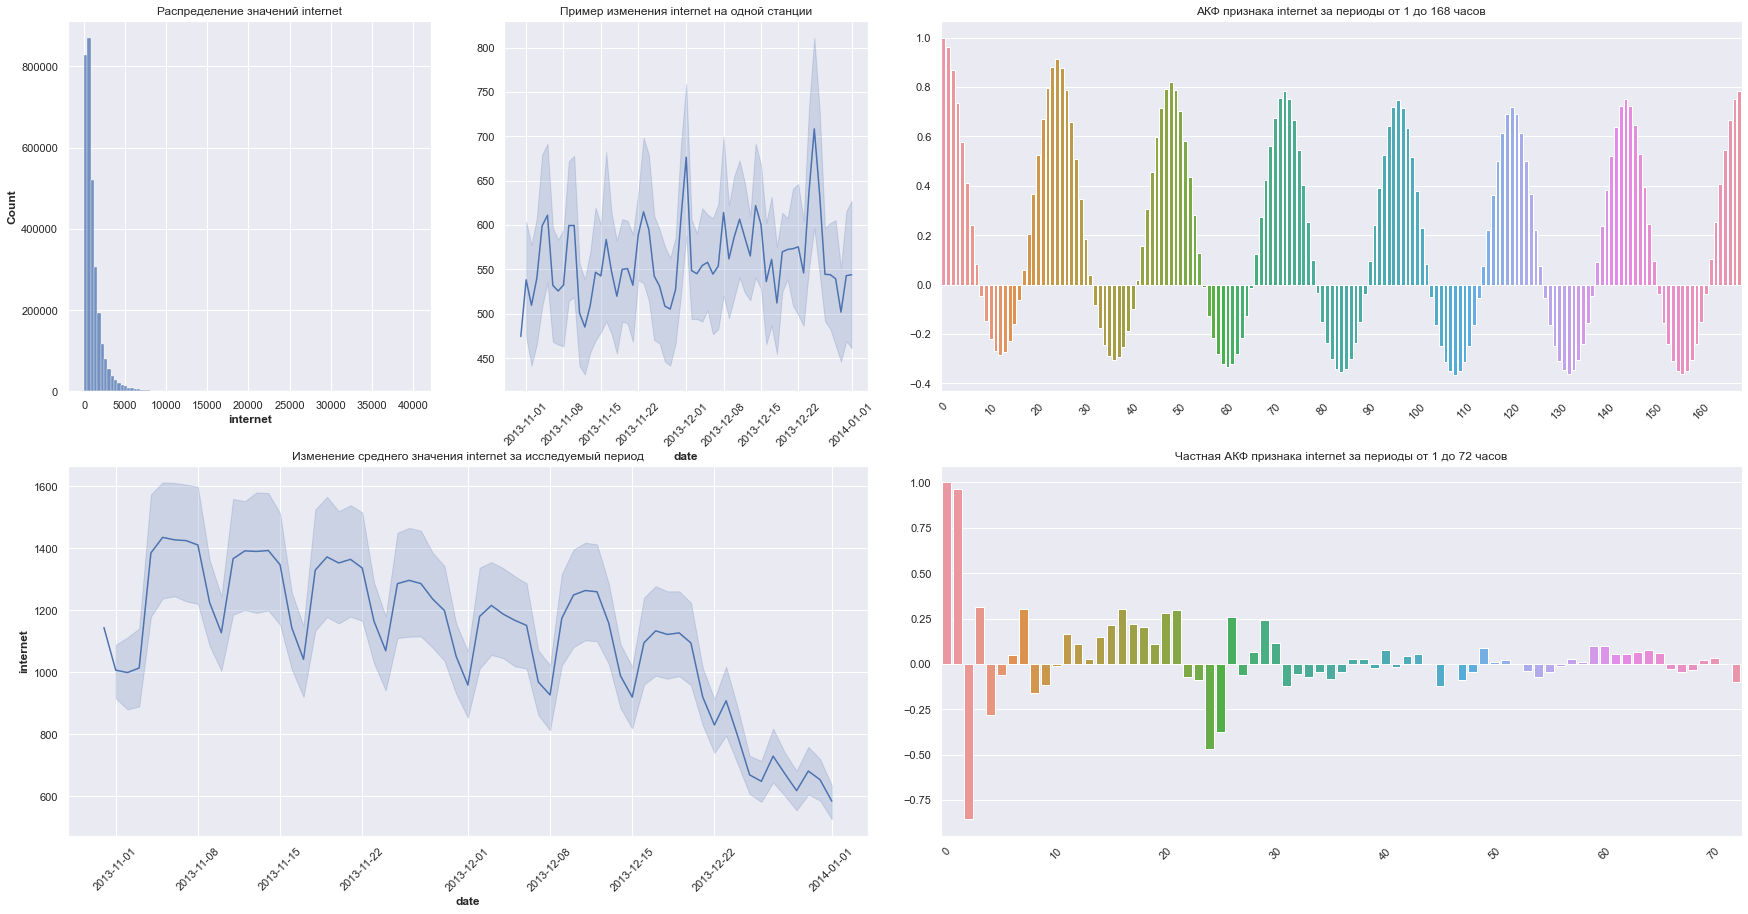

In [7]:
vis_col(df, 'internet', scaled=False)

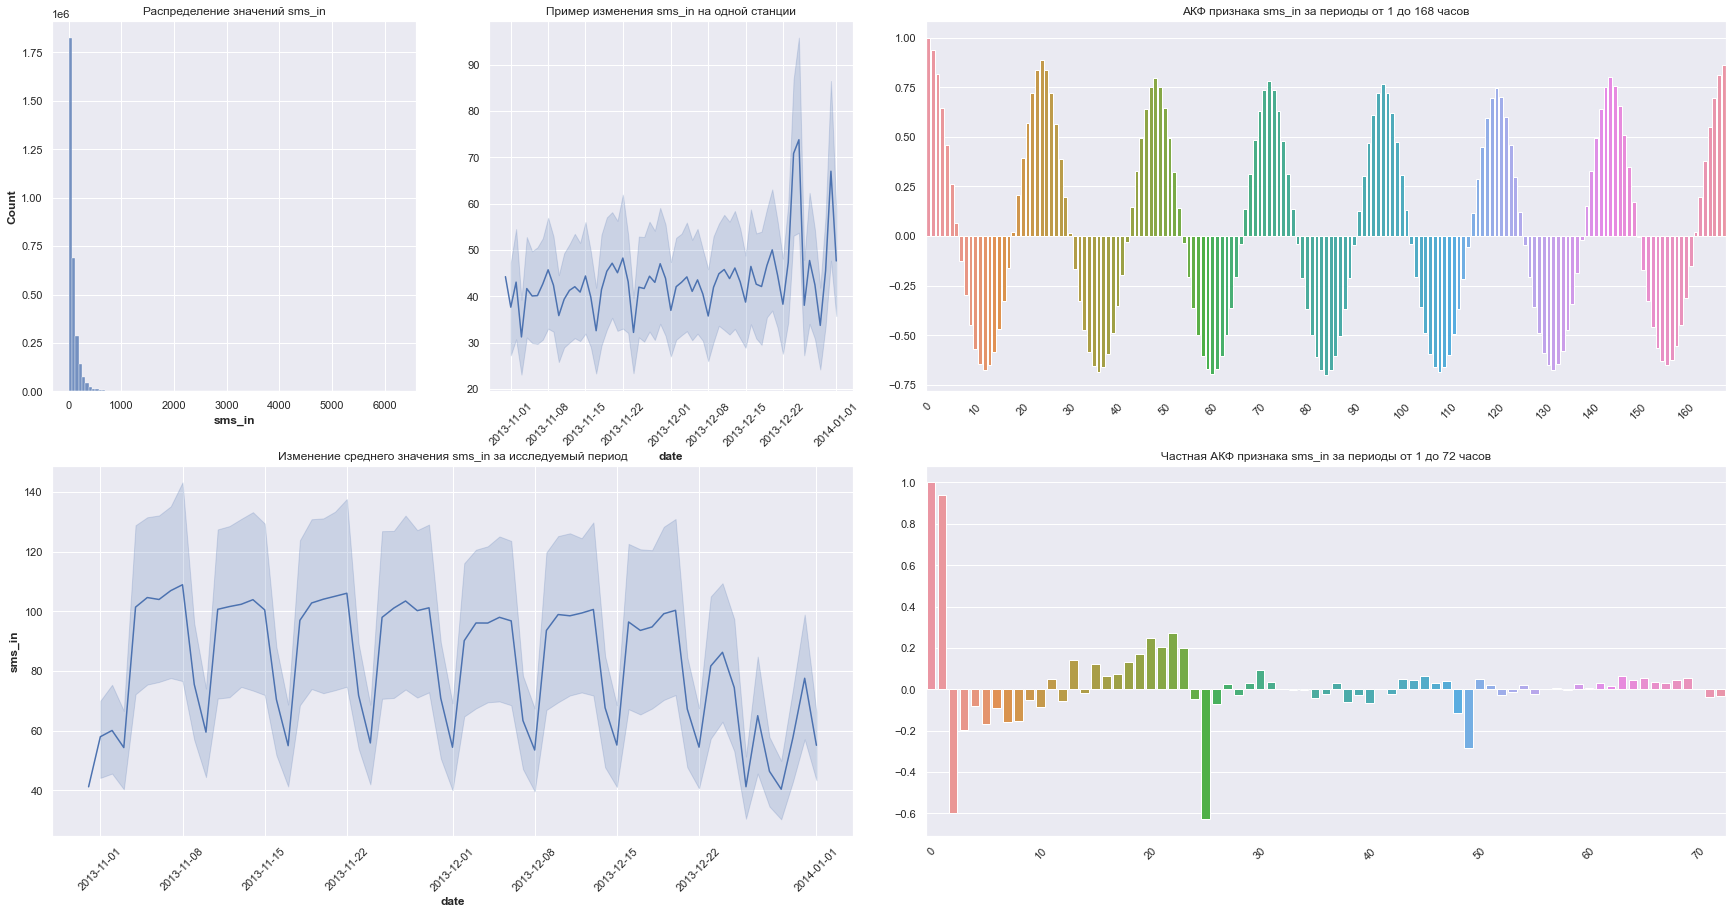

In [8]:
vis_col(df, 'sms_in')

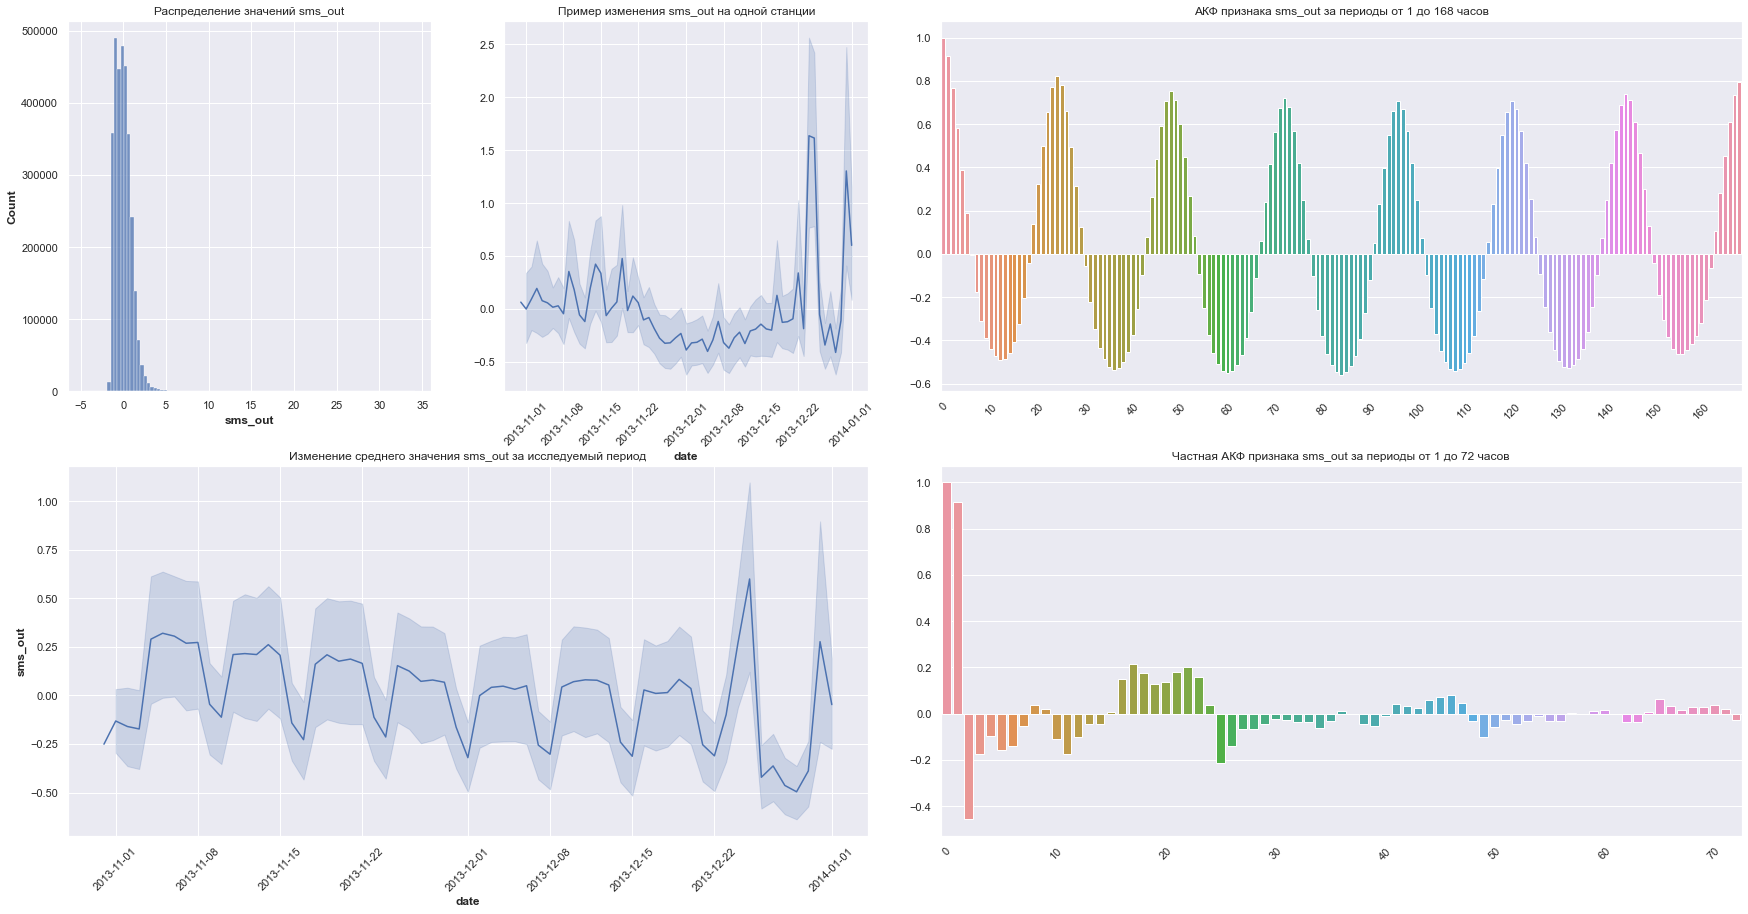

In [9]:
vis_col(df, 'sms_out', scaled=True)

#### Проверка на стационарность

In [10]:
p_vals = []
for s in tqdm(df.square_id.unique()[:200]):
    row = df[df.square_id==s].internet
    p = sm.tsa.stattools.adfuller(row)[1]
    p_vals.append(p)

  0%|          | 0/200 [00:00<?, ?it/s]

In [11]:
p_vals_box = []
for s in tqdm(df.square_id.unique()[:200]):
    row, lmbda = stats.boxcox(df[df.square_id==s].internet)
    p = sm.tsa.stattools.adfuller(row)[1]
    p_vals_box.append(p)

  0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
p_vals_stationary = []
for s in tqdm(df.square_id.unique()[:200]):
    row, lmbda = stats.boxcox(df[df.square_id==s].internet)
    row = pd.Series(row) - pd.Series(row).shift(24)
    p = sm.tsa.stattools.adfuller(row[24:])[1]
    p_vals_stationary.append(p)

  0%|          | 0/200 [00:00<?, ?it/s]

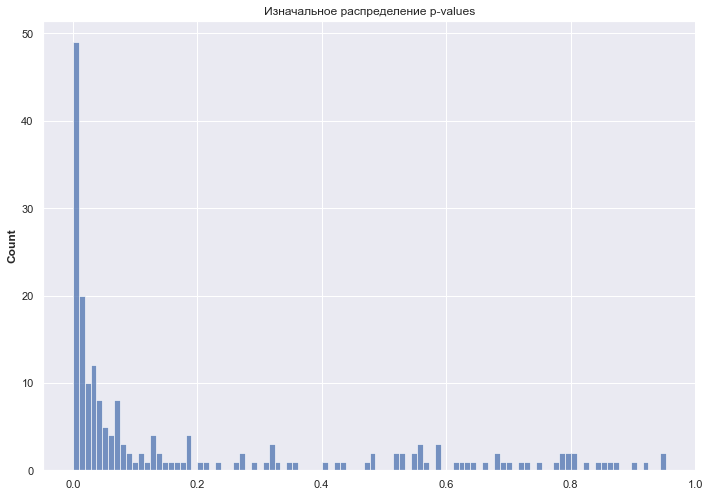

In [13]:
plt.title('Изначальное распределение p-values')
sns.histplot(p_vals, bins=100);

<AxesSubplot:title={'center':'Распределение p-values после преобразования Бокса-Кокса'}, ylabel='Count'>

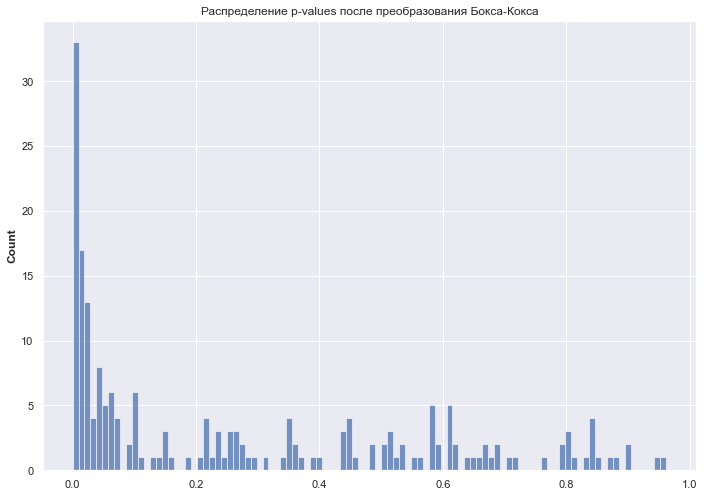

In [14]:
plt.title('Распределение p-values после преобразования Бокса-Кокса')
sns.histplot(p_vals_box, bins=100)

<AxesSubplot:title={'center':'Распределение p-values после сезонного дифференцирования'}, ylabel='Count'>

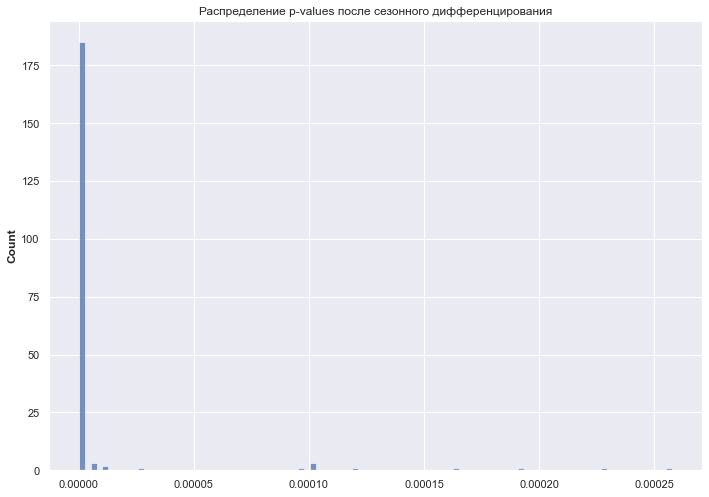

In [15]:
plt.title('Распределение p-values после сезонного дифференцирования')
sns.histplot(p_vals_stationary, bins=100)

NameError: name '_agg' is not defined

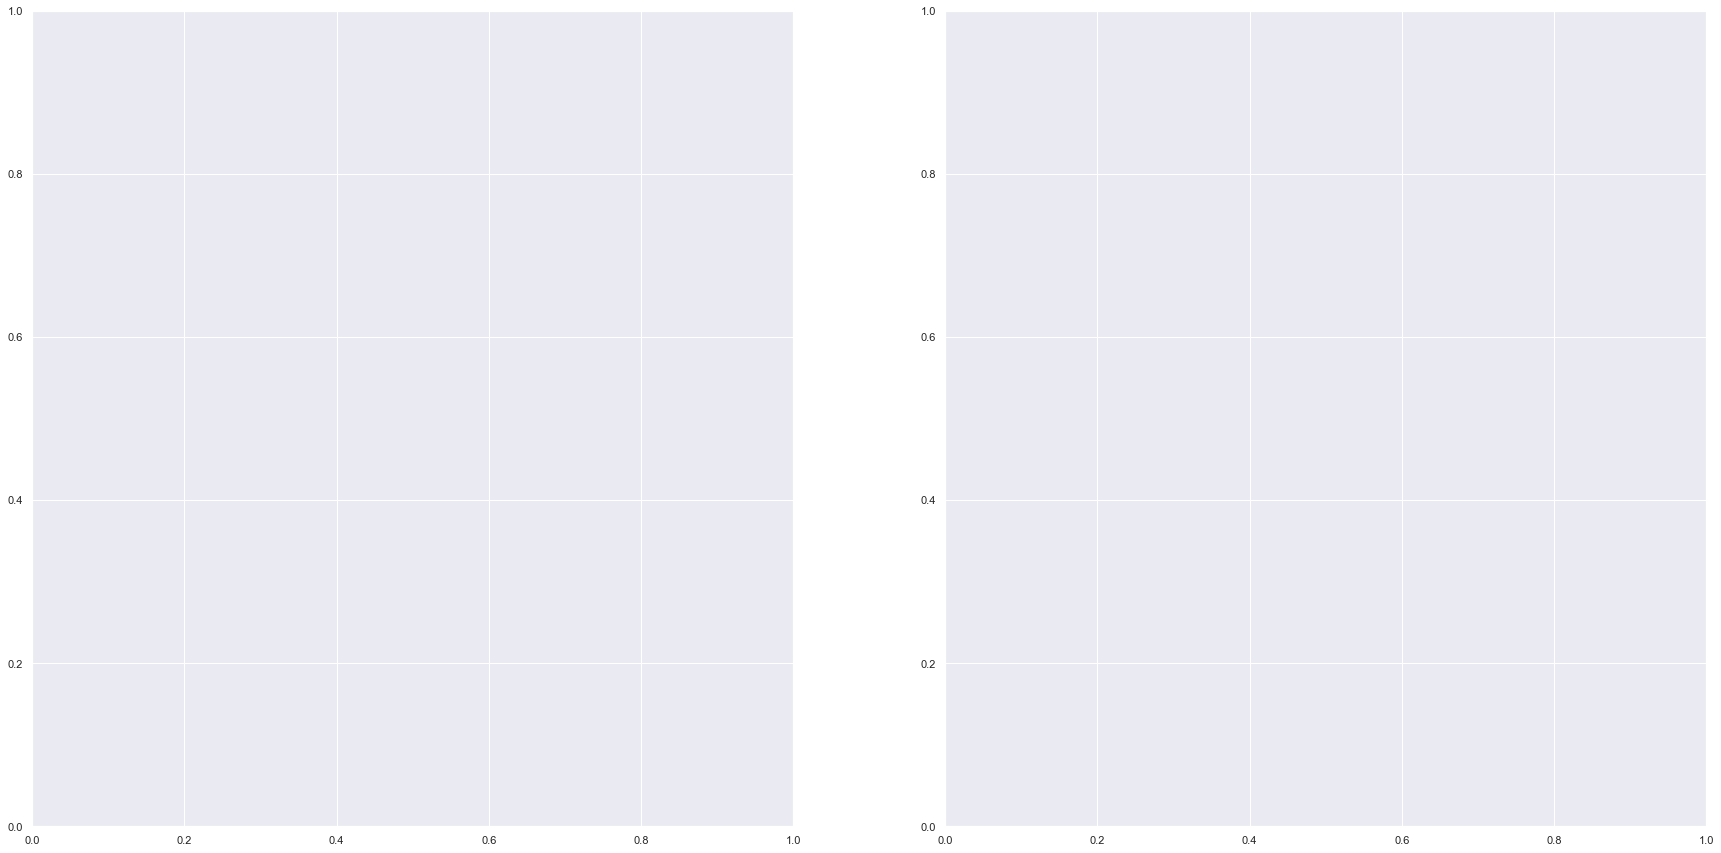

In [16]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(30,15))

nlags = 24 * 7 
corrs, ccnf_intervals = ts.acf(_agg, 
                               nlags=nlags, 
                               alpha=.05)
sns.barplot(x=np.arange(0,nlags+1), y=corrs, ax=axs[0],).set(title=f'АКФ признака {col} за периоды от 1 до {nlags} часов');
axs[0].xaxis.set_ticks(np.arange(0, nlags+1, 10))
axs[0].tick_params(axis='x', rotation=45)


nlags = 72
corrs, ccnf_intervals = ts.pacf(_agg, 
                             nlags=nlags, 
                             alpha=.05)
sns.barplot(x=np.arange(0,nlags+1), y=corrs, ax=axs[1],).set(title=f'Частная АКФ признака internet за периоды от 1 до {nlags} часов');
axs[1].xaxis.set_ticks(np.arange(0, nlags+1, 10))
axs[1].tick_params(axis='x', rotation=45)



